To preform our analysis we will utilise scanpy. Scanpy is a scalable Python library designed for analyzing and visualizing single-cell gene expression data, particularly from RNA-seq experiments. It provides efficient tools for preprocessing (normalization, filtering, etc.), dimensionality reduction (PCA, UMAP, t-SNE), clustering, differential expression, and trajectory inference. Built on top of AnnData objects, it integrates well with the broader scientific Python ecosystem (NumPy, Pandas, SciPy, scikit-learn), and is optimized for handling large datasets. Although scanpy is designed for gene level analysis it can just as easily handle Isoform resoloution single cell data when combined with additional tools

In [1]:
import scanpy as sc

Here we will use a built in scanpy function to read in the data.

In [2]:
import allos.preprocessing as pp
adata = pp.process_mouse_data()


🔎 Looking for file at: /home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/resources/data/mouse_1.txt.gz to /home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /home/train/longTREC/software/miniconda3/envs/Single_Cel

/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Long‑read scRNA‑seq and the ScNaUmi‑seq strategy  

**Oxford Nanopore** sequencing delivers reads that span entire transcripts, directly revealing exon structure and RNA modifications.  
However, raw Nanopore error rates (~5 % at time of publication) complicate accurate cell‑barcode (CB) and unique molecular identifier (UMI) assignment.  
The *ScNaUmi‑seq* workflow addresses this by:  

1.  Using the standard 10x droplet chemistry for barcoding thousands of cells.  
2.  Performing an extra full‑length PCR, then Nanopore sequencing for depth.  
3.  **Guiding CB/UMI recovery with matched Illumina short‑read data,** achieving ~99.8 % CB and ~97 % UMI accuracy.  
4.  Collapsing reads that share a UMI to build high‑accuracy (≥99 %) consensus sequences per molecule. 

This hybrid design combines Illumina’s accuracy with Nanopore’s read length, enabling high‑throughput, isoform‑resolved single‑cell transcriptomics. Due to the increasing accuracy of ONT data matched short read data is no longer a neccescity.


In [3]:
from allos.transcript_plots import TranscriptPlots
import os
import urllib.request
from pathlib import Path

# Example Ensembl URLs for mouse GRCm39 (release 109)
gtf_url = "ftp://ftp.ensembl.org/pub/release-109/gtf/mus_musculus/Mus_musculus.GRCm39.109.gtf.gz"

# Store data one directory back
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)

gtf_file_local = data_dir / "Mus_musculus.GRCm39.109.gtf.gz"

# Download if not already present
if not gtf_file_local.is_file():
    print(f"Downloading {gtf_url}...")
    urllib.request.urlretrieve(gtf_url, gtf_file_local)

from allos.transcript_plots import TranscriptPlots




tp = TranscriptPlots(gtf_file=str(gtf_file_local))


/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Lets take a look at our data. An AnnData object is a core data structure used in Scanpy to store single-cell data, including gene or isoform expression counts. It organizes the expression matrix alongside rich metadata: cell-level annotations (.obs), feature-level annotations (.var), and optional layers like normalized data, embeddings (.obsm), and graphs (.obsp). It supports both in-memory and on-disk (HDF5-backed) storage, making it efficient for large-scale single-cell transcriptomics datasets.

In [48]:
adata.obs.cell_type.unique()

['mature Glutamatergic', 'Cajal-Retzius', 'imature Glutamatergic', 'intermediate progenitor', 'radial glia', 'cycling radial glia', 'imature GABAergic', 'mature GABAergic']
Categories (8, object): ['Cajal-Retzius', 'cycling radial glia', 'imature GABAergic', 'imature Glutamatergic', 'intermediate progenitor', 'mature GABAergic', 'mature Glutamatergic', 'radial glia']

Single‑cell RNA‑seq (scRNA‑seq) has transformed our ability to chart cellular diversity, but most droplet‑based protocols (e.g. 10x Genomics Chromium) only read ~100 bp at one end of each cDNA.  That is enough for gene‑level quantification, yet it discards information on **alternative splicing, RNA editing, chimeric transcripts and allele‑specific expression**—all critical layers of regulation in complex tissues like the brain.  Consequently, important biological variation is hidden when we collapse all isoforms of a gene into a single count vector.


Scanpy uses the AnnData object to store single cell data. n_obs = 1109: This means there are 1109 observations — typically cells or nuclei.

n_vars = 24917: There are 24, 917 variables — typically features, such as genes, isoforms, exons, or junctions. Given the high number, this likely reflects transcript- or isoform-level resolution (not just genes).



In [5]:
adata.var

,geneId
transcriptId,
ENSMUST00000156717.1,Klc2
ENSMUST00000212520.1,Capn15
ENSMUST00000025798.12,Klc2
ENSMUST00000231280.1,Eva1c
ENSMUST00000039286.4,Atg5
...,...
ENSMUST00000127375.1,Snx11
ENSMUST00000125687.1,Camta2
ENSMUST00000139277.7,Atp5o


The .var of an anndata object is a Pandas dataframe. Pandas is a Python library for data manipulation and analysis, built around two core structures: DataFrame (2D tables) and Series (1D arrays). It provides fast, intuitive tools for filtering, transforming, summarizing, and joining structured data. This makes it really easy to preform any manipulations we may need. Lets get our .var in a more usable format.

Lets take a quick look at an individual gene CLTA and examine some of its transcripts.

In [6]:
# sanity check
print("\nAll CLTA isoforms still present:")
display(adata.var.query("geneId == 'Clta'").head())



All CLTA isoforms still present:


,geneId
transcriptId,
ENSMUST00000107851.9,Clta
ENSMUST00000107845.3,Clta
ENSMUST00000107846.9,Clta
ENSMUST00000170241.7,Clta
ENSMUST00000107849.9,Clta


# Unique Molecular Identifiers (UMIs): what and why?  

UMIs are random 8–12 nt tags added during reverse transcription to **label each original RNA molecule**. After sequencing they let us:  

- Collapse PCR duplicates, removing amplification bias.  
- Build per‑molecule consensus sequences to correct sequencing errors.  
- Quantify absolute transcript numbers more faithfully than read counts.

Lets have a look at the number of UMIs we have per cell.




/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


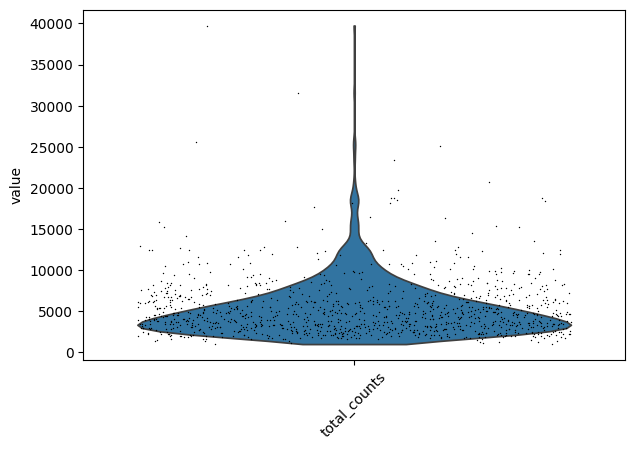

In [7]:
# Quick sanity‑check: how many UMIs did we recover per cell?
import scanpy as sc

sc.pp.calculate_qc_metrics(adata, inplace=True)    # adds "total_counts" = UMI sum per cell
sc.pl.violin(adata, ['total_counts'], jitter=0.4, rotation=45)


Violin plot of total UMI counts per cell, with each dot representing one cell’s molecule load.
Most cells cluster around 3–8 k UMIs

## From isoforms to genes: why and how?

Your long‑read matrix has one row per **transcript isoform**.  
When you convert it to a **gene‑level** matrix you simply add together all UMIs whose isoforms originate from the same gene.  


Most downstream workflows (clustering, differential expression, pathway analysis) expect a *gene × cell* matrix, so converting lets you plug long‑read data into the standard single‑cell toolbox.



In [8]:
adata_gene = pp.get_sot_gene_matrix(adata)


# The dataset used in this practical  

| Parameter | Value | Notes |
|-----------|-------|-------|
| Source tissue | E18 mouse cortex + hippocampus | late‑gestation brain, rich in neurogenesis |
| Cells profiled | 951 + 190 technical replicates | split at emulsion step |
| Reads | 322 M + 32 M Nanopore; 70 M + 43 M Illumina | PromethION + NextSeq |
| Median genes / cell (Illumina) | 2 739 | gene‑level reference |
| Median isoform UMIs / cell (Nanopore) | 3 795 | after CB/UMI assignment |  



/tmp/ipykernel_140187/3063236797.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("cell_type").mean()


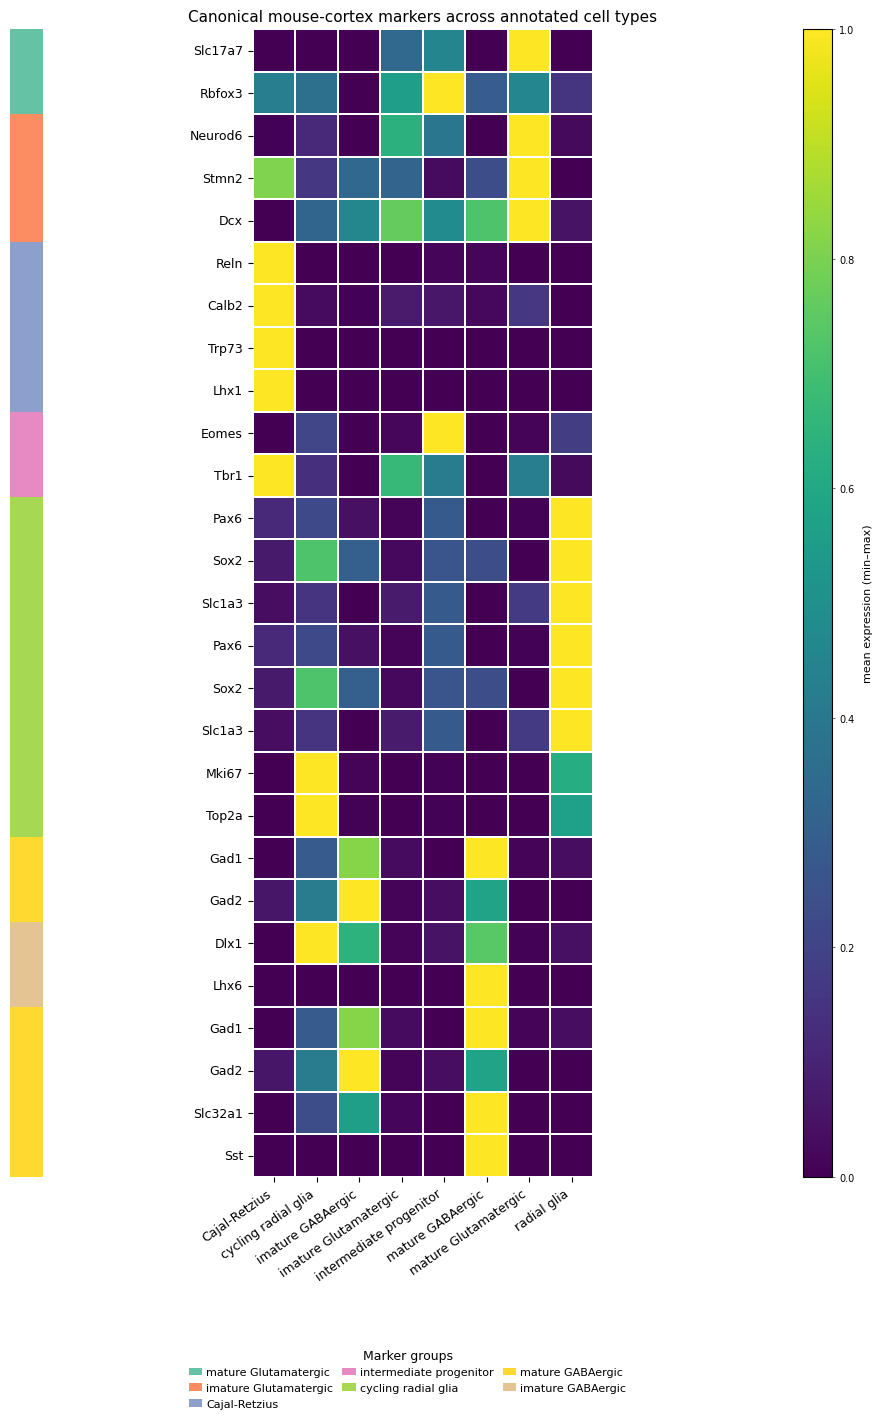

In [9]:
"""
Heat‑map of canonical markers for eight embryonic mouse cortical cell types.
---------------------------------------------------------------------------
Requirements
    scanpy, pandas, numpy, seaborn, matplotlib
Input
    adata_gene  – AnnData with:
        • adata_gene.obs["cell_type"]  (eight classes)
        • adata_gene.var_names containing the genes below
"""

# ──────────────────────────────
# 0 ▸  Imports
# ──────────────────────────────
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import gridspec

# ──────────────────────────────
# 1 ▸  Marker genes
# ──────────────────────────────
marker_sets = {
    # excitatory lineage
    "mature Glutamatergic":      ["Slc17a7", "Camk2a", "Rbfox3"],
    "imature Glutamatergic":     ["Neurod6", "Stmn2", "Dcx"],
    "Cajal-Retzius":             ["Reln", "Calb2", "Trp73", "Lhx1"],
    "intermediate progenitor":   ["Eomes", "Neurod1", "Tbr1"],
    # radial‑glia lineage
    "radial glia":               ["Pax6", "Sox2", "Slc1a3"],
    "cycling radial glia":       ["Pax6", "Sox2", "Slc1a3", "Mki67", "Top2a"],
    # inhibitory lineage
    "imature GABAergic":         ["Gad1", "Gad2", "Dlx1", "Lhx6"],
    "mature GABAergic":          ["Gad1", "Gad2", "Slc32a1", "Pvalb", "Sst"],
}

# ──────────────────────────────
# 2 ▸  Mean‑expression matrix
# ──────────────────────────────
order_genes = [
    g
    for block in marker_sets.values()
    for g in block
    if g in adata_gene.var_names                    # keep genes that exist
]
mean_exp = (
    adata_gene[:, order_genes]
    .to_df()
    .join(adata_gene.obs["cell_type"])
    .groupby("cell_type").mean()
    .T
)
# drop zero rows, then min–max scale per gene
mean_exp = mean_exp.loc[lambda df: df.sum(axis=1) != 0]
scaled   = (mean_exp - mean_exp.min(axis=1).values[:, None]) / (
             mean_exp.max(axis=1) - mean_exp.min(axis=1)
           ).values[:, None]

# ──────────────────────────────
# 3 ▸  Row‑strip showing marker groups
# ──────────────────────────────
block_lookup = {g: b for b, genes in marker_sets.items() for g in genes}
row_blocks   = pd.Series(scaled.index).map(block_lookup)
pal_blocks   = dict(
    zip(
        pd.unique(row_blocks),
        sns.color_palette("Set2", n_colors=row_blocks.nunique()),
    )
)
strip_rgb = np.vstack(row_blocks.map(pal_blocks)).reshape(len(row_blocks), 1, 3)

# ──────────────────────────────
# 4 ▸  Figure layout
# ──────────────────────────────
fig = plt.figure(
    figsize=(1.05 * scaled.shape[1] + 2.2,
             0.50 * scaled.shape[0] + 1.6)
)
gs = gridspec.GridSpec(
    nrows=1,
    ncols=3,
    width_ratios=[0.04, 0.925, 0.035],
    wspace=0.03,
)

# left colour strip
ax_strip = fig.add_subplot(gs[0, 0])
ax_strip.imshow(strip_rgb, aspect="auto")
ax_strip.axis("off")

# heat‑map
ax_hm = fig.add_subplot(gs[0, 1])
sns.heatmap(
    scaled,
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.25,
    linecolor="white",
    cbar=False,
    ax=ax_hm,
)
ax_hm.set_xticklabels(ax_hm.get_xticklabels(), rotation=35, ha="right", fontsize=9)
ax_hm.set_yticklabels(ax_hm.get_yticklabels(), rotation=0,  ha="right", fontsize=9)
ax_hm.set_title(
    "Canonical mouse‑cortex markers across annotated cell types",
    fontsize=11,
    pad=6,
)
ax_hm.set_xlabel("")
ax_hm.set_ylabel("")

# colour‑bar
ax_cb = fig.add_subplot(gs[0, 2])
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(0, 1))
cb = plt.colorbar(sm, cax=ax_cb)
cb.set_label("mean expression (min–max)", fontsize=8, labelpad=6)
cb.ax.tick_params(labelsize=7, width=0.4, length=2)

# ──────────────────────────────
# 5 ▸  Legend (marker‑group colours)
# ──────────────────────────────
handles = [Patch(facecolor=pal_blocks[b], label=b) for b in pal_blocks]
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.04),
    ncol=len(handles) // 2 if len(handles) > 6 else len(handles),
    frameon=False,
    fontsize=8,
    title="Marker groups",
    title_fontsize=9,
    handlelength=1.2,
    handletextpad=0.4,
    columnspacing=0.8,
)

plt.subplots_adjust(bottom=0.12)   # space for legend text
plt.show()


| row‑block                   | key markers (this data)                    | biological interpretation                                                                                                                                                                                                                                                                                                                 |
| --------------------------- | ------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **mature Glutamatergic**    | `Slc17a7`, `Camk2a`, `Rbfox3`              | VGLUT1 (*Slc17a7*) loads glutamate into vesicles, while CaMKII‑α (*Camk2a*) and the neuron‑specific splicing factor NeuN (*Rbfox3*) rise as pyramidal neurons finish migration, extend long‑range axons and acquire synaptic plasticity machinery—hallmarks of fully differentiated excitatory cortex. ([UniProt][1], [PMC][2], [PMC][3]) |
| **imature Glutamatergic**   | `Neurod6`, `Stmn2`, `Dcx`                  | These are newly born excitatory neurons exiting the subventricular zone. *Neurod6* triggers glutamatergic fate, STMN2 supports neurite outgrowth, and DCX marks migrating, growth‑cone‑bearing precursors; together they define the “newborn/early‑migratory” window before NeuN/VGLUT1 switch‑on. ([Cell][4], [Abcam][5])                |
| **Cajal‑Retzius**           | `Reln`, `Calb2`, `Trp73`, `Lhx1`           | Layer‑I pioneer neurons that secrete Reelin (*Reln*) to orchestrate cortical lamination. High TRP73 is considered the most specific CR marker, CALB2 decorates their horizontal dendrites, and LHX1 participates in early fate specification. ([PMC][6], [Nature][7])                                                                     |
| **Intermediate progenitor** | `Eomes` (*Tbr2*), `Neurod1`, `Tbr1`        | Tbr2⁺ transit‑amplifying progenitors leave the ventricular surface, divide in the subventricular zone and commit to deep‑layer neuron fate (progressing Pax6 → Tbr2 → Tbr1). *Neurod1* marks the earliest post‑mitotic step of this cascade. ([PMC][8], [ScienceDirect][9])                                                               |
| **Radial glia**             | `Pax6`, `Sox2`, `Slc1a3`                   | Apical radial glia are the neural stem cells of the embryonic cortex. PAX6 and SOX2 maintain multipotency, while GLAST (*Slc1a3*) clears extracellular glutamate and typifies ventricular fibres. ([PMC][10])                                                                                                                             |
| **Cycling radial glia**     | `Pax6`, `Sox2`, `Slc1a3`, `Mki67`, `Top2a` | The same stem‑cell core, but co‑expression of MKI67 and TOP2A flags cells in S/G₂/M, identifying the actively dividing subset that generates both IPs and neurons. ([Nature][7])                                                                                                                                                          |
| **imature GABAergic**       | `Gad1`, `Gad2`, `Dlx1`, `Lhx6`             | Post‑mitotic interneuron precursors from the medial ganglionic eminence. DLX1 drives Gad1/2 expression (GABA synthesis), and LHX6 directs tangential migration toward cortex; neuropeptide genes are still silent. ([PMC][11])                                                                                                            |
| **mature GABAergic**        | `Gad1`, `Gad2`, `Slc32a1`, `Pvalb`, `Sst`  | Fully integrated inhibitory interneurons: Gad1/2 keep GABA supply high, VGAT (*Slc32a1*) loads it into vesicles, and diverging expression of parvalbumin or somatostatin marks the principal cortical interneuron subclasses. ([PMC][12], [Frontiers][13])                                                                                |

[1]: https://www.uniprot.org/uniprotkb/Q3TXX4/entry?utm_source=chatgpt.com "Vesicular glutamate transporter 1 - Mus musculus (Mouse) | UniProtKB"
[2]: https://pmc.ncbi.nlm.nih.gov/articles/PMC6616294/?utm_source=chatgpt.com "CAMK2-Dependent Signaling in Neurons Is Essential for Survival"
[3]: https://pmc.ncbi.nlm.nih.gov/articles/PMC11980809/?utm_source=chatgpt.com "Characterization of the Rbfox3‐IRES‐iCre knock‐in mouse"
[4]: https://www.cell.com/cell/pdf/S0092-8674%2822%2901168-0.pdf?utm_source=chatgpt.com "Proper acquisition of cell class identity in organoids allows definition ..."
[5]: https://www.abcam.com/en-us/technical-resources/research-areas/marker-guides/immature-neuron-markers?srsltid=AfmBOopt9W0iwwk8dEkwSYUvKNZPy2E7izDBf2S-XvxVav1Iq2cI7rlV&utm_source=chatgpt.com "Immature neuron and intermediate progenitor markers - Abcam"
[6]: https://pmc.ncbi.nlm.nih.gov/articles/PMC10585607/?utm_source=chatgpt.com "A Versatile Strategy for Genetic Manipulation of Cajal–Retzius Cells ..."
[7]: https://www.nature.com/articles/s41467-018-08079-9?utm_source=chatgpt.com "Single-cell transcriptomic analysis of mouse neocortical development"
[8]: https://pmc.ncbi.nlm.nih.gov/articles/PMC6656625/?utm_source=chatgpt.com "Intermediate progenitors and Tbr2 in cortical development - PMC"
[9]: https://www.sciencedirect.com/science/article/pii/S2211124716306854?utm_source=chatgpt.com "Intermediate Progenitor Cohorts Differentially Generate Cortical ..."
[10]: https://pmc.ncbi.nlm.nih.gov/articles/PMC4583716/?utm_source=chatgpt.com "Molecular Identity of Human Outer Radial Glia During Cortical ..."
[11]: https://pmc.ncbi.nlm.nih.gov/articles/PMC6290988/?utm_source=chatgpt.com "Development and functional diversification of cortical interneurons"
[12]: https://pmc.ncbi.nlm.nih.gov/articles/PMC10330559/?utm_source=chatgpt.com "The Nature of Prefrontal Cortical GABA Neuron Alterations in ..."
[13]: https://www.frontiersin.org/journals/cellular-neuroscience/articles/10.3389/fncel.2024.1414955/full?utm_source=chatgpt.com "Genetic approaches to elucidating cortical and hippocampal ..."


### Dimensionality reduction on genes *vs.* isoforms  

Whether you feed PCA/UMAP the **gene‑level matrix** (`adata_gene`) or the richer **isoform‑level matrix** (`adata`), the low‑dimensional embeddings – and therefore the clusters – tend to be nearly identical.  Multiple long‑read studies (e.g. Lebrigand et al., 2020; Tian et al., 2023) report that cell identity is driven by the aggregate expression of parent genes, so collapsing isoforms rarely alters the global manifold.  In practice you can run PCA on the highly variable features of either matrix, confident that downstream clustering and annotation will converge on the same biological cell types. However minor differences have been observed and these could underly important biological variation.



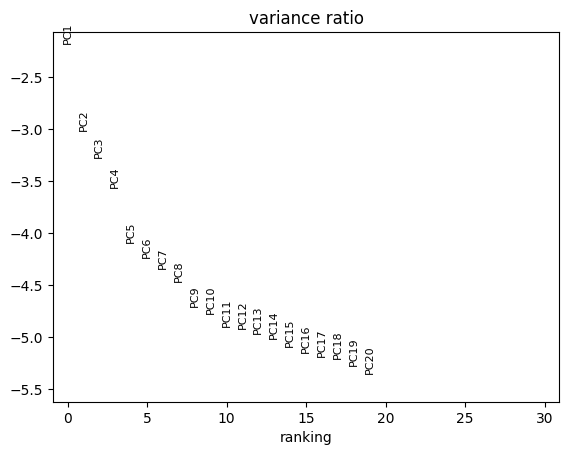

/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


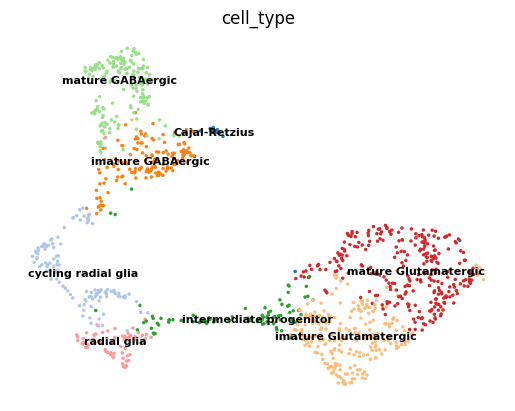

In [10]:
import allos.preprocessing as pp



# Make a copy of the gene matrix data to preserve it
original_gene_anndata = adata_gene.copy()
sc.pp.filter_cells(adata_gene, min_genes=500)

# Perform the operations on the gene matrix
sc.pp.normalize_total(adata_gene, target_sum=1e4)
sc.pp.log1p(adata_gene)

# Select the top 2000 highly variable genes for gene_anndata
sc.pp.highly_variable_genes(adata_gene, n_top_genes=2000)
gene_anndata = adata_gene[:, adata_gene.var.highly_variable]

sc.tl.pca(adata_gene, svd_solver='arpack', n_comps=20)
sc.pl.pca_variance_ratio(adata_gene, log=True)     # elbow plot → pick n_pcs

sc.pp.neighbors(adata_gene)

sc.tl.umap(
    adata_gene,
    min_dist=0.3,       # 0.1 → tighter clusters; 0.5 → broader
    spread=1.0,
    random_state=0
)

sc.pl.umap(
    adata_gene,
    color='cell_type',
    palette=sc.pl.palettes.vega_20,   # avoids similar colours
    frameon=False,
    size=25,            # adjust point size
    legend_loc='on data',
    legend_fontsize=8
)

# Restore the original gene matrix data
adata_gene = original_gene_anndata

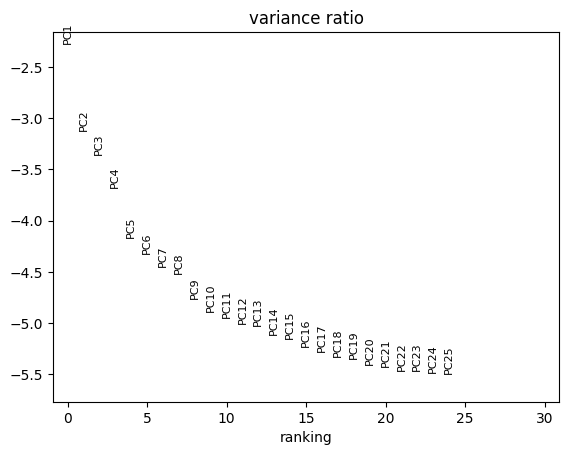

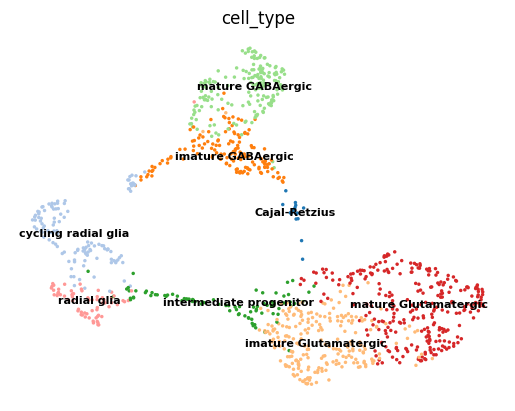

In [11]:
import scanpy as sc

# Make a copy of the original data to preserve it
original_sicelore_mouse_data = adata.copy()
sc.pp.filter_cells(adata, min_genes=500)

# Perform the operations
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Select the top 5000 highly variable transcripts
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sicelore_mouse_data = adata[:, adata.var.highly_variable]


sc.tl.pca(adata, svd_solver='arpack', n_comps=25)
sc.pl.pca_variance_ratio(adata, log=True)     # elbow plot → pick n_pcs

sc.pp.neighbors(adata)
sc.tl.umap(
    adata,
    min_dist=0.3,       # 0.1 → tighter clusters; 0.5 → broader
    spread=1.0,
    random_state=0
)

sc.pl.umap(
    adata,
    color='cell_type',
    palette=sc.pl.palettes.vega_20,   # avoids similar colours
    frameon=False,
    size=25,            # adjust point size
    legend_loc='on data',
    legend_fontsize=8
)



adata_t = adata
# Restore the original data
adata = original_sicelore_mouse_data

Although QC was already preformed on the gene matrix - its best to check out the isoform matrix to ensure everything is as expected with no suprises.

In [12]:
sc.pp.calculate_qc_metrics(adata_gene, percent_top=None, log1p=False, inplace=True)

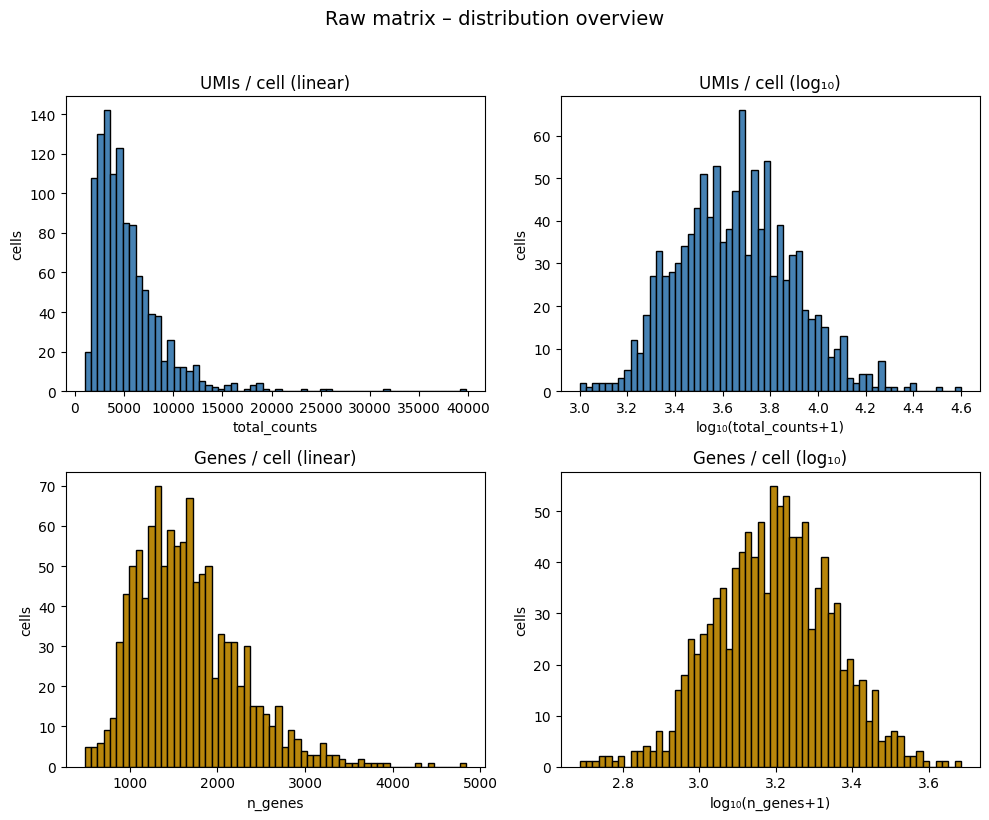

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

# ── total_counts ──────────────────────────────────────────────
ax = axes[0,0]
adata_gene.obs['total_counts'].plot.hist(
    bins=60, ax=ax, color='steelblue', edgecolor='black'
)
ax.set_title("UMIs / cell (linear)")
ax.set_xlabel("total_counts")
ax.set_ylabel("cells")

# log-scale view
ax = axes[0,1]
np.log10(adata_gene.obs['total_counts']+1).plot.hist(
    bins=60, ax=ax, color='steelblue', edgecolor='black'
)
ax.set_title("UMIs / cell (log₁₀)")
ax.set_xlabel("log₁₀(total_counts+1)")
ax.set_ylabel("cells")

# ── n_genes_by_counts ─────────────────────────────────────────
ax = axes[1,0]
adata_gene.obs['n_genes_by_counts'].plot.hist(
    bins=60, ax=ax, color='darkgoldenrod', edgecolor='black'
)
ax.set_title("Genes / cell (linear)")
ax.set_xlabel("n_genes")
ax.set_ylabel("cells")

ax = axes[1,1]
np.log10(adata_gene.obs['n_genes_by_counts']+1).plot.hist(
    bins=60, ax=ax, color='darkgoldenrod', edgecolor='black'
)
ax.set_title("Genes / cell (log₁₀)")
ax.set_xlabel("log₁₀(n_genes+1)")
ax.set_ylabel("cells")

plt.suptitle("Raw matrix – distribution overview", y=1.02, fontsize=14)
plt.tight_layout()


Depth: Raw UMI counts are strongly right‑skewed—most cells sit around 2–8 k molecules, but a small tail stretches to ~40 k, reflecting varying capture efficiency.

Library complexity: Gene counts peak near 1–1.5 k genes per cell and follow the same log‑normal pattern; the log‑scaled panels look roughly bell‑shaped, suggesting uniform sequencing quality with no obvious low‑quality sub‑population.


### Allos

Allos is a Scanpy-centric add-on that brings long-read, isoform-resolved single-cell data into the familiar AnnData world. It wraps a set of purpose-built modules—pre-processing, annotation helpers, isoform-level QC, switch-detection, and publication-style plots—around the core scverse API, so every function takes and returns standard AnnData objects. Because it leans on Scanpy for neighbours, clustering and embedding, you can run gene-level workflows exactly as usual and then drop straight into isoform-aware analyses without duplicating the dataset or re-learning a new object model.

In this notebook we tap three Allos modules: preprocessing to trim low-abundance transcripts (filter_transcripts_by_abundance), SwitchSearch to call differential isoform usage across cell types and the plotting helpers (plot_isoform_heatmap, TranscriptPlots) to visualise isoform expression and long-read coverage side-by-side with our gene-level UMAP. That tight integration lets us start from the same QC-filtered AnnData, branch into isoform granularity, and still feed results back into Scanpy or any other scverse tool without loss of metadata—a clean, end-to-end bridge between short-read practice and long-read discovery.

In [14]:
import allos.preprocessing as pp

In [15]:
adata = pp.filter_transcripts_by_abundance(adata,  threshold_pct = 2)

In [16]:
adata

AnnData object with n_obs × n_vars = 1109 × 24917
    obs: 'batch', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'geneId', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

pp.filter_transcripts_by_abundance() prunes the rows of the AnnData matrix, keeping only those transcripts that register non-zero counts in at least threshold_pct % of cells. With threshold_pct = 3 the isoform must appear in ≥ 3 % of the post-QC barcodes—roughly 300 cells in a 10 k-cell PBMC run—to survive. This cut eliminates the long tail of ultra-rare or one-off splice-variants that mostly reflect ambient reads and PCR noise, drops matrix width by an order of magnitude, and speeds every downstream step (neighbor graph, DE, switch tests) without sacrificing population-informative isoforms.

Why isoforms matter in the nervous system  

- **Alternative splicing** expands the neuronal proteome, modulating ion‑channel gating, synaptic scaffolding and axon guidance. More than half of all mammalian genes produce multiple splice variants, and neuronal tissues show the highest isoform diversity. 
- Developmental stage–specific splicing programmes refine cell identity; classic examples include PSD‑95 (DLG4) and NMDAR subunits in maturing synapses.
- Mis‑splicing is implicated in neurodevelopmental and neurodegenerative disorders, underscoring the need for isoform‑level resolution in functional genomics studies.  


In [17]:
from allos.switch_search import SwitchSearch

SwitchSearch is Allos’ convenience wrapper for differential-isoform-usage screens.
When you instantiate it with

In [18]:
ss = SwitchSearch(adata, group_columns='cell_type')

You tell Allos two things: Where the counts live – it takes your current adata, whose rows are transcripts/isoforms and whose columns are cells. How to group the cells – it will bucket cells by the categorical column celltypist_majority_voting (e.g. “Naïve B”, “CD16⁺ NK”, …). Under the hood the object caches per-group transcript sums, cell counts and other bookkeeping, so later calls like




In [19]:
DIU_results = ss.find_switches_chi2(
            primary_col="cell_type",
            within="primary",
            return_transcript_metrics=False,
            calc_effect_size=True,
            effect_size_mode="signed")

/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/switch_search.py:559: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["gene_id", "group_1", "group_2"])["delta_psi"]


can run a χ² (or other) test for each gene to ask: does the relative isoform composition differ across those annotated cell types? In short, the line above sets up all the heavy data slicing once, so every subsequent switch-detection or effect-size calculation is fast and uses the exact same grouping definition. find_switches_chi2 asks a classic χ² test of independence for every multi-isoform gene:
Build a contingency table – for gene G, Allos sums raw counts so that rows = isoforms of G and columns = cell-type groups (taken from celltypist_majority_voting). Each cell in the table is the total number of UMIs that isoform received in that cell type.

Null hypothesis – the relative isoform composition of G is the same in every cell type (i.e. usage is independent of group).The χ² statistic compares observed counts with the counts expected under that null; high deviations give low p-values, flagging genes whose splice-form proportions shift across cell identities.

In [20]:
DIU_results_sorted = DIU_results.sort_values(by="adj_pval", ascending=True)


Lets take a look at the results of the switch test. What’s in DIU_results?
find_switches_chi2() emits one row per gene for every pair of cell-type groups that you asked it to compare. With within="primary" the function first performs an omnibus χ² across all groups; it then expands that into all pairwise contrasts so you can see exactly which two cell types drive each gene-level switch. For each comparison you get:

| column                        | meaning                                                                                                                                                              |
| ----------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `gene_id`                     | Ensembl or HGNC symbol for the parent gene.                                                                                                                          |
| `group_1`, `group_2`          | The two cell‑type labels drawn from `celltypist_majority_voting`.                                                                                                    |
| `chi2_stat`, `dof`, `p_value` | Classical χ² statistic, its degrees‑of‑freedom = (#isoforms − 1) and raw *P*.                                                                                        |
| `adj_pval`                    | Benjamini–Hochberg FDR across **all** pairwise rows.                                                                                                                 |
| `effect_size`                 | Signed Cramér’s V: positive if the major‑shifted isoform is enriched in `group_1`, negative if enriched in `group_2`; magnitude reflects switch strength.            |
| `delta_pi`                    | Tilgner Δπ effect size: sum of the two largest isoform‑usage differences between groups, bounded –1 … 1; sign is positive when the dominant shift favours `group_1`. |


If you had called the function with return_transcript_metrics=True you’d receive an extra table keyed by gene_id, transcript_id, group that reports per-isoform log-fold-change, %-spliced-in and the residual contribution of each isoform to the global χ². The gene-level frame you sorted (DIU_results_sorted) is therefore ideal for a volcano/Manhattan plot or for sub-setting the top significant switches, while the optional transcript-level frame lets you dig into which isoform(s) flipped between the two cell types.

In [21]:
DIU_results_sorted

,gene_id,group_1,group_2,chi2_stat,p_value,dof,adj_pval,effect_size
128,Pkm,cycling radial glia,mature Glutamatergic,1143.749269,1.024230e-250,1,3.130048e-247,0.660202
364,Pkm,intermediate progenitor,mature Glutamatergic,806.015722,2.655468e-177,1,4.057554e-174,0.645525
50,Pkm,cycling radial glia,imature Glutamatergic,561.650730,3.677313e-124,1,3.745956e-121,0.517946
103,Clta,cycling radial glia,mature Glutamatergic,493.165339,2.917931e-109,1,2.229299e-106,-0.555046
87,Pkm,cycling radial glia,mature GABAergic,364.909877,2.401553e-81,1,1.467829e-78,0.536311
...,...,...,...,...,...,...,...,...
277,Celf2,imature Glutamatergic,mature Glutamatergic,7.272401,7.002215e-03,1,4.852329e-02,0.088866
76,Ctbp1,cycling radial glia,mature GABAergic,7.253891,7.074757e-03,1,4.891506e-02,0.267887
196,Ttc3,imature GABAergic,mature GABAergic,7.241503,7.123730e-03,1,4.914248e-02,-0.119490
173,Npm1,imature GABAergic,imature Glutamatergic,7.222121,7.201057e-03,1,4.956403e-02,-0.061891


In [22]:
g1, g2 = "radial glia", "mature Glutamatergic"          # spellings from .obs

b_switches = (DIU_results
                .loc[lambda d:
                     ((d.group_1 == g1) & (d.group_2 == g2)) |
                     ((d.group_1 == g2) & (d.group_2 == g1))]
                .sort_values("adj_pval")
                .reset_index(drop=True))

print(b_switches[["gene_id", "effect_size", "adj_pval"]].head(30))


      gene_id  effect_size      adj_pval
0        Myl6    -0.468127  6.380032e-60
1        Tecr    -0.436542  2.679682e-45
2        Rtn4     0.470054  1.118602e-37
3      Hnrnpk    -0.222425  1.042385e-15
4        Meg3     0.393041  4.823653e-14
5      Polr1d    -0.258314  1.514343e-10
6       Vps29    -0.189801  3.273639e-09
7     Smarcb1    -0.192630  5.200247e-09
8       Mtch1     0.197606  3.287167e-07
9        Nasp    -0.198670  1.836938e-06
10        Set    -0.195662  4.321055e-06
11    Hnrnpa3    -0.141902  5.208540e-06
12      Atp5j    -0.100695  8.618943e-05
13        Fus     0.199587  7.112797e-04
14       Nnat     0.282328  7.729964e-04
15     Zfp207    -0.155456  9.880101e-04
16      Eif4h    -0.194581  1.598368e-03
17     Rps27a    -0.008477  3.990295e-03
18  Hnrnpa2b1     0.083765  4.301195e-03
19    Hnrnpa1     0.084806  5.028714e-03
20      Dtymk    -0.344011  7.375611e-03
21       Rps9    -0.044421  9.142736e-03
22     Atp5g1     0.159019  1.045483e-02
23      H2afv   

In [23]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", message="findfont: .*", module="matplotlib")

# ───────────────────────────────────────────────────────────────────────
# helper 1: draw ONE volcano panel on a given Axes
# ───────────────────────────────────────────────────────────────────────
def draw_volcano_panel(
    ax,
    df_comp,                         # dataframe for ONE (group1, group2)
    *,
    effect_col="effect_size",
    pval_col="adj_pval",
    fdr_cutoff=0.05,
    eff_cutoff=0.10,
    top_n=6,
    bg_size=10,                      # marker areas (pt²)
    sig_size=25,
    font_size=7,
):
    """Draws a Δπ vs FDR volcano into *ax* (NO fig.show/save here)."""
    # ── prep & masks ────────────────────────────────────────────────────
    df = df_comp.copy()
    df["neg_log10_p"] = -np.log10(df[pval_col].clip(lower=1e-300))
    sig = (df[pval_col] < fdr_cutoff) & (df[effect_col].abs() >= eff_cutoff)

    # unique top‑n labels by |Δπ|
    top = (df.loc[sig]
             .drop_duplicates("gene_id")
             .assign(abs_eff=lambda x: x[effect_col].abs())
             .nlargest(top_n, "abs_eff"))

    # ── scatter points ──────────────────────────────────────────────────
    ax.scatter(df.loc[~sig, effect_col], df.loc[~sig, "neg_log10_p"],
               s=bg_size, color="#BFBFBF", alpha=.6, zorder=1)
    ax.scatter(df.loc[sig,  effect_col], df.loc[sig,  "neg_log10_p"],
               s=sig_size, color="#C23B3B", alpha=.85, zorder=2)

    # ── thresholds ──────────────────────────────────────────────────────
    ax.axhline(-np.log10(fdr_cutoff), color="k", ls="--", lw=.8)
    ax.axvline( eff_cutoff,  color="k", ls="--", lw=.8)
    ax.axvline(-eff_cutoff, color="k", ls="--", lw=.8)

    # ── gene‑label stubs (placed first) ─────────────────────────────────
    texts, anchors = [], []          # anchors = original dot positions
    for _, r in top.iterrows():
        x0, y0 = r[effect_col], r["neg_log10_p"]
        anchors.append((x0, y0))
        texts.append(
            ax.text(x0, y0, r["gene_id"],
                    ha="center", va="bottom",
                    fontsize=font_size, color="#C23B3B")
        )

    # ── repel labels -----------------------------------------------------
    try:
        # nicest solution if the user *does* happen to have the lib
        from adjustText import adjust_text
        adjust_text(texts, ax=ax,
                    expand_points=(1.1, 1.35),
                    arrowprops=dict(arrowstyle="-", lw=.4, color="#666"))
    except ModuleNotFoundError:
        # ----------------------------------------------------------------
        # dependency‑free fallback:  minimal vertical / horizontal nudging
        # ----------------------------------------------------------------
        def _bbox(text):
            """helper: text bbox in *data* coords (≈ fast & good‑enough)."""
            renderer = ax.figure.canvas.get_renderer()
            bb_disp  = text.get_window_extent(renderer=renderer)
            return bb_disp.transformed(ax.transData.inverted())

        # iterate over labels, bump until no overlap with any placed label
        for i, txt in enumerate(texts):
            # start *slightly* above the dot
            x, y = anchors[i]
            y += 0.05 * ax.get_ylim()[1]

            txt.set_position((x, y))
            iteration, moved = 0, True
            while moved and iteration < 100:
                moved = False
                bb = _bbox(txt)
                for j, other in enumerate(texts):
                    if j == i: continue
                    if _bbox(other).overlaps(bb):
                        # push current txt upward by a small step
                        x_old, y_old = txt.get_position()
                        step = 0.02 * ax.get_ylim()[1]
                        txt.set_position((x_old, y_old + step))
                        bb   = _bbox(txt)
                        moved = True
                iteration += 1

        # light arrow from label back to its dot (clarity when far apart)
        for t, (x0, y0) in zip(texts, anchors):
            ax.annotate("",
                        xy=(x0, y0), xycoords="data",
                        xytext=t.get_position(), textcoords="data",
                        arrowprops=dict(arrowstyle="-", lw=.4, color="#666"))

    # ── clip any labels that wander outside frame ───────────────────────
    x_lo, x_hi = ax.get_xlim()
    y_lo, y_hi = ax.get_ylim()
    for t in texts:
        x, y = t.get_position()
        t.set_position((np.clip(x, x_lo + 0.02, x_hi - 0.02),
                        min(y, y_hi - 0.5)))

    # ── cosmetics ───────────────────────────────────────────────────────
    ax.set_xlabel("Δπ", fontsize=font_size + 1)
    ax.set_ylabel("−log$_{10}$ FDR", fontsize=font_size + 1)

    xmax = np.ceil(df[effect_col].abs().max() * 1.1 / 0.05) * 0.05
    ax.set_xlim(-xmax, xmax)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):d}"))
    ax.tick_params(labelsize=font_size)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # title = comparison name
    g1, g2 = df["group_1"].iat[0], df["group_2"].iat[0]
    ax.set_title(f"{g1}  vs  {g2}", fontsize=font_size + 2, pad=4)

    return ax


# ───────────────────────────────────────────────────────────────────────
# helper 2: make a GRID of all comparisons on one sheet
# ───────────────────────────────────────────────────────────────────────
def volcano_grid(
    df_all,
    *,
    n_cols=3,
    figsize_per_panel=3.0,      # inches
    save=None,                  # "all_volcanos.pdf" / ".svg" / None
    show=True,
    **panel_kw                  # forwarded to draw_volcano_panel
):
    """
    Draw every (group_1, group_2) combo in df_all on one figure grid.

    Parameters
    ----------
    n_cols : int
        How many columns in the grid.
    figsize_per_panel : float
        Size of each small square panel (inches).
    save : str | Path | None
        Path to save the full figure; skipped if None.
    show : bool
        Whether to display the figure inline.
    panel_kw : dict
        Extra kwargs for `draw_volcano_panel` (cut-offs, sizes, etc.).
    """
    comparisons = list(df_all.groupby(["group_1", "group_2"]))
    n_panels = len(comparisons)
    n_rows = int(np.ceil(n_panels / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols*figsize_per_panel, n_rows*figsize_per_panel),
        dpi=300,
        squeeze=False
    )

    # flatten axes for easy iteration
    ax_iter = axes.flatten()
    for idx, ((g1, g2), subdf) in enumerate(comparisons):
        draw_volcano_panel(
            ax_iter[idx],
            subdf,
            **panel_kw
        )

    # turn off unused axes
    for ax in ax_iter[n_panels:]:
        ax.axis("off")

    fig.tight_layout()

    if save:
        Path(save).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save, bbox_inches="tight")

    if show:
        plt.show(block=False)  # Ensure the plot is shown only once
    else:
        plt.close(fig)

    return fig



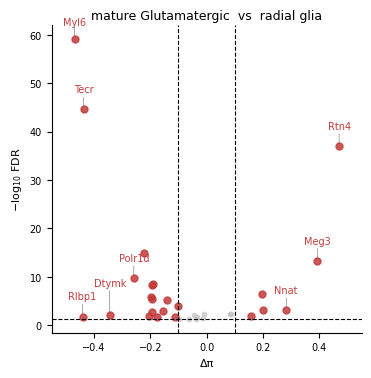

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter   # used inside the helper

# ── 1 · pick the two labels exactly as they occur in DIU_results ─────────
g1, g2 = "radial glia", "mature Glutamatergic"  

# ── 2 · subset the DIU frame to this comparison (order-agnostic) ─────────
df_comp = DIU_results.loc[
    ((DIU_results.group_1 == g1) & (DIU_results.group_2 == g2)) |
    ((DIU_results.group_1 == g2) & (DIU_results.group_2 == g1))
].copy()

if df_comp.empty:
    raise ValueError("Requested comparison not found in DIU_results")

# ── 3 · draw the panel ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(4, 4))
draw_volcano_panel(
    ax,
    df_comp,
    fdr_cutoff=0.05,      # red if FDR < 5 %
    eff_cutoff=0.10,      # Δπ threshold lines
    top_n=8               # annotate the eight strongest switches
)
plt.show()

# (optional) save for your figure panel
# fig.savefig("volcano_NaiveB_vs_MemoryB.png", dpi=300, bbox_inches="tight")


In [25]:
import io
from typing import Optional, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


def plot_isoform_heatmap(
    adata_lr: sc.AnnData,
    gene_id: str,
    cell_col: str,
    top_n: int = 5,
    view_mode: str = "EXP",
    subset_col: str = "celltype_lv0_V6",
    subset_vals: Sequence[str] = (),
    subset_cell: Sequence[str] = (),
    remove_low: bool = True,
    adata_sr: Optional[sc.AnnData] = None,
) -> plt.Figure:
    """
    Generate a heatmap of isoform expression for a given gene.

    Parameters
    ----------
    adata_lr : sc.AnnData
        Long-read AnnData containing isoform counts/log-expression.
    gene_id : str
        Gene identifier to plot.
    cell_col : str
        Column in adata.obs to use as cell-type grouping on the x-axis.
    top_n : int
        Number of top isoforms to include (by mean expression).
    view_mode : str
        One of {"EXP", "PSI", "PCT"}:
        - "EXP": average log1p expression;
        - "PSI": percent spliced-in per isoform;
        - "PCT": percent of cells expressing the isoform.
    subset_col : str
        Column in adata.obs to filter compartments (optional).
    subset_vals : Sequence[str]
        Values of subset_col to keep; empty means all.
    subset_cell : Sequence[str]
        Specific cell types to include; empty means apply remove_low filter.
    remove_low : bool
        If True, drop cell types with < 30 cells (ignored if subset_cell is provided).
    adata_sr : Optional[sc.AnnData]
        Short-read AnnData for EXP view; adds an extra row if provided.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The resulting heatmap figure.
    """
    # Filter by compartment subset
    if subset_vals:
        mask = adata_lr.obs[subset_col].isin(subset_vals)
        if not mask.any():
            raise ValueError("No cells match selected compartment subset.")
        ad = adata_lr[mask].copy()
    else:
        ad = adata_lr

    # Select isoforms for the gene
    iso_mask = ad.var["geneId"] == gene_id
    isoforms = ad.var_names[iso_mask]
    if len(isoforms) == 0:
        raise ValueError(f"No isoforms found for gene '{gene_id}'")

    # Expression matrix and grouping labels
    expr_df = ad[:, isoforms].to_df()
    groups = ad.obs[cell_col]

    # Determine valid cell types
    if subset_cell:
        valid_ct = list(subset_cell)
    else:
        counts = groups.value_counts()
        if remove_low:
            valid_ct = counts[counts >= 30].index.tolist()
        else:
            valid_ct = counts.index.tolist()
    if not valid_ct:
        raise ValueError("No cell types remain after filtering.")

    # Filter cells
    keep = groups.isin(valid_ct)
    expr_df = expr_df[keep]
    groups = groups[keep]

    # Limit to top N isoforms
    if top_n and expr_df.shape[1] > top_n:
        top_iso = expr_df.mean().nlargest(top_n).index
        expr_df = expr_df[top_iso]

    # Compute summary matrix
    if view_mode == "PSI":
        total = expr_df.sum(axis=1).replace(0, np.nan)
        val_df = expr_df.div(total, axis=0).assign(ct=groups.values).groupby("ct").mean().T * 100
        cbar_label, fmt = "PSI (%)", "%.1f"
    elif view_mode == "PCT":
        val_df = expr_df.gt(0).assign(ct=groups.values).groupby("ct").mean().T * 100
        cbar_label, fmt = "% expressed", "%.0f"
    else:  # EXP
        val_df = expr_df.assign(ct=groups.values).groupby("ct").mean().T
        cbar_label, fmt = ("log1p EXP", "%.2f")

        # Append short-read row if available
        if adata_sr is not None and gene_id in adata_sr.var_names:
            sr = adata_sr
            if subset_vals and subset_col in sr.obs.columns:
                sr = sr[sr.obs[subset_col].isin(subset_vals)]
            sr_df = pd.concat([sr.to_df()[[gene_id]], sr.obs[[cell_col]]], axis=1)
            sr_mean = sr_df.groupby(cell_col)[gene_id].mean()
            sr_mean = sr_mean.reindex(valid_ct).dropna()
            val_df.loc[f"{gene_id}-SR"] = sr_mean.values

    # Reorder if subset_cell provided
    if subset_cell:
        val_df = val_df.loc[:, [ct for ct in subset_cell if ct in val_df.columns]]

    # Plot heatmap
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(1.8 * val_df.shape[1], 0.7 * (val_df.shape[0] + 4)))
    sns.heatmap(
        val_df,
        cmap=sns.color_palette("rocket_r", as_cmap=True),
        linewidths=0.3,
        linecolor="#f0f0f0",
        cbar_kws=dict(label=cbar_label, format=fmt),
        ax=ax,
    )
    ax.set_title(f"{gene_id} – {cbar_label}")
    ax.set_xlabel("Cell type")
    ax.set_ylabel("Isoform")
    # Annotate x-axis labels with counts
    ticks = []
    for ct in val_df.columns:
        n = (groups == ct).sum()
        ticks.append(f"{ct} (n={n})")
    ax.set_xticklabels(ticks, rotation=35, ha="right", fontsize=10)
    # Rotate y-axis labels for isoform/transcript IDs
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=10)
    fig.tight_layout()
    return fig


In [26]:
from allos.switch_search import get_top_n_isoforms

In [49]:
top_n = get_top_n_isoforms(adata=adata, gene_id = 'Myl6', top_n = 4, strip=True)

In [50]:
import allos.visuals as vs


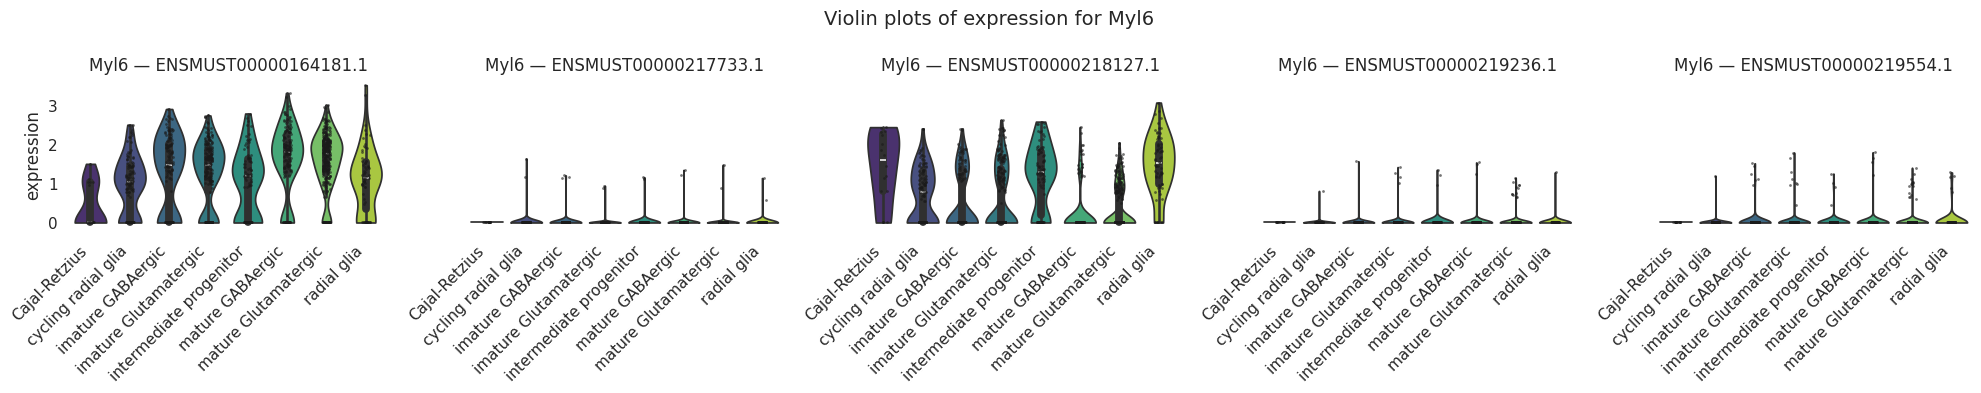

In [51]:
vs.plot_transcript_expression_violin(adata_t, gene_id='Myl6')


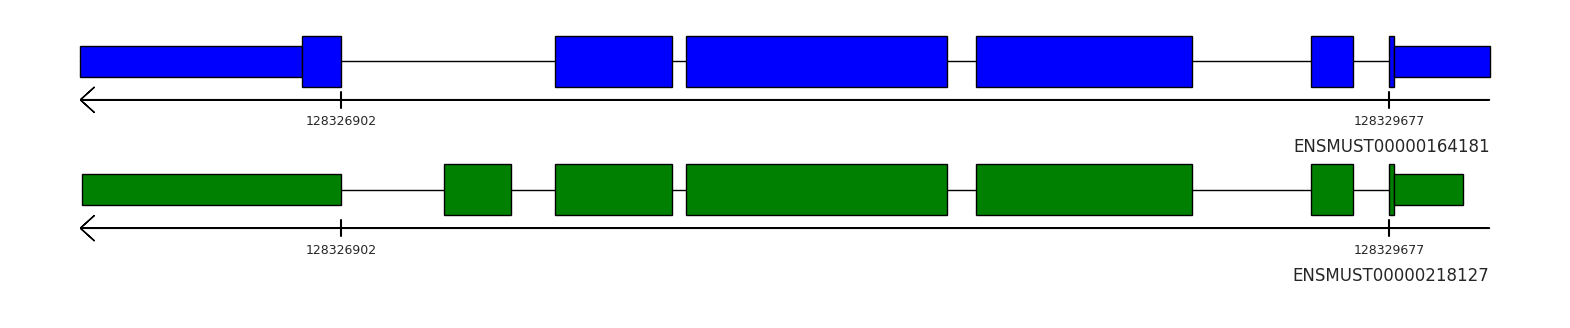

In [52]:
tp.draw_transcripts_list(transcripts_ids=top_n, draw_cds=True)

In [32]:
import allos.visuals as vs

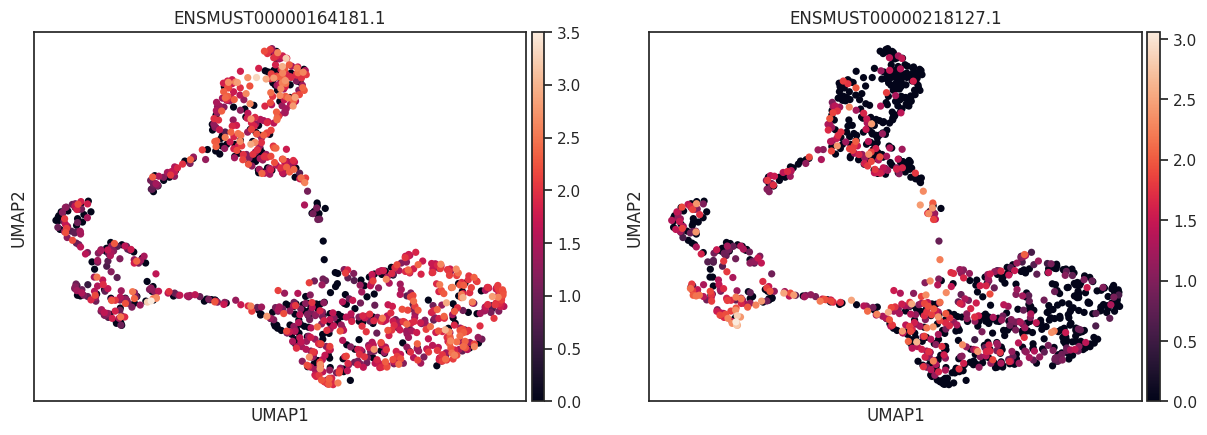

In [34]:
top_n = get_top_n_isoforms(adata=adata, gene_id = 'Myl6', top_n = 4, strip=False)
vs.plot_transcripts(adata_t, transcripts=top_n)


/tmp/ipykernel_140187/1183139680.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_df = expr_df.div(total, axis=0).assign(ct=groups.values).groupby("ct").mean().T * 100


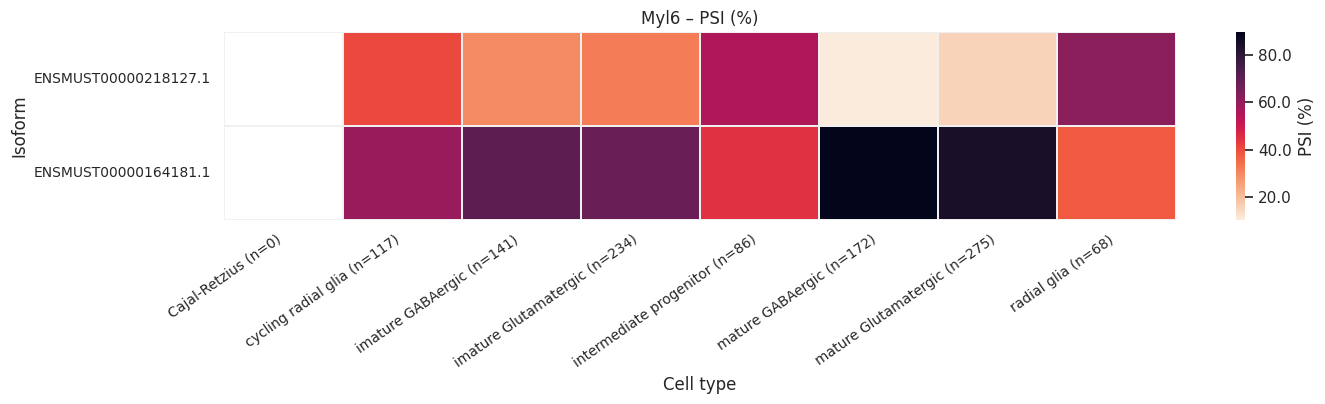

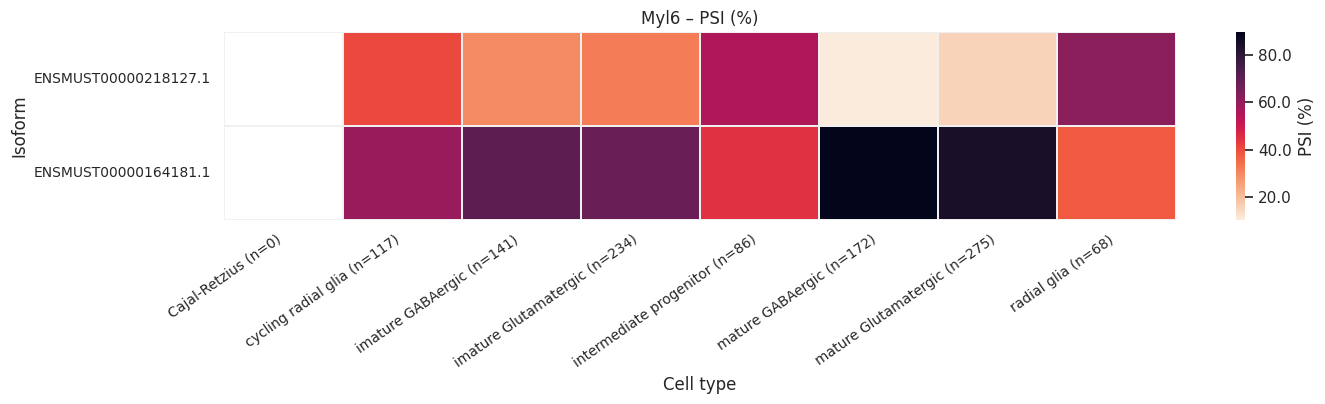

In [35]:
plot_isoform_heatmap(adata_lr=adata, cell_col='cell_type', gene_id='Myl6', view_mode='PSI')

/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/visuals.py:474: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right', fontsize=11)


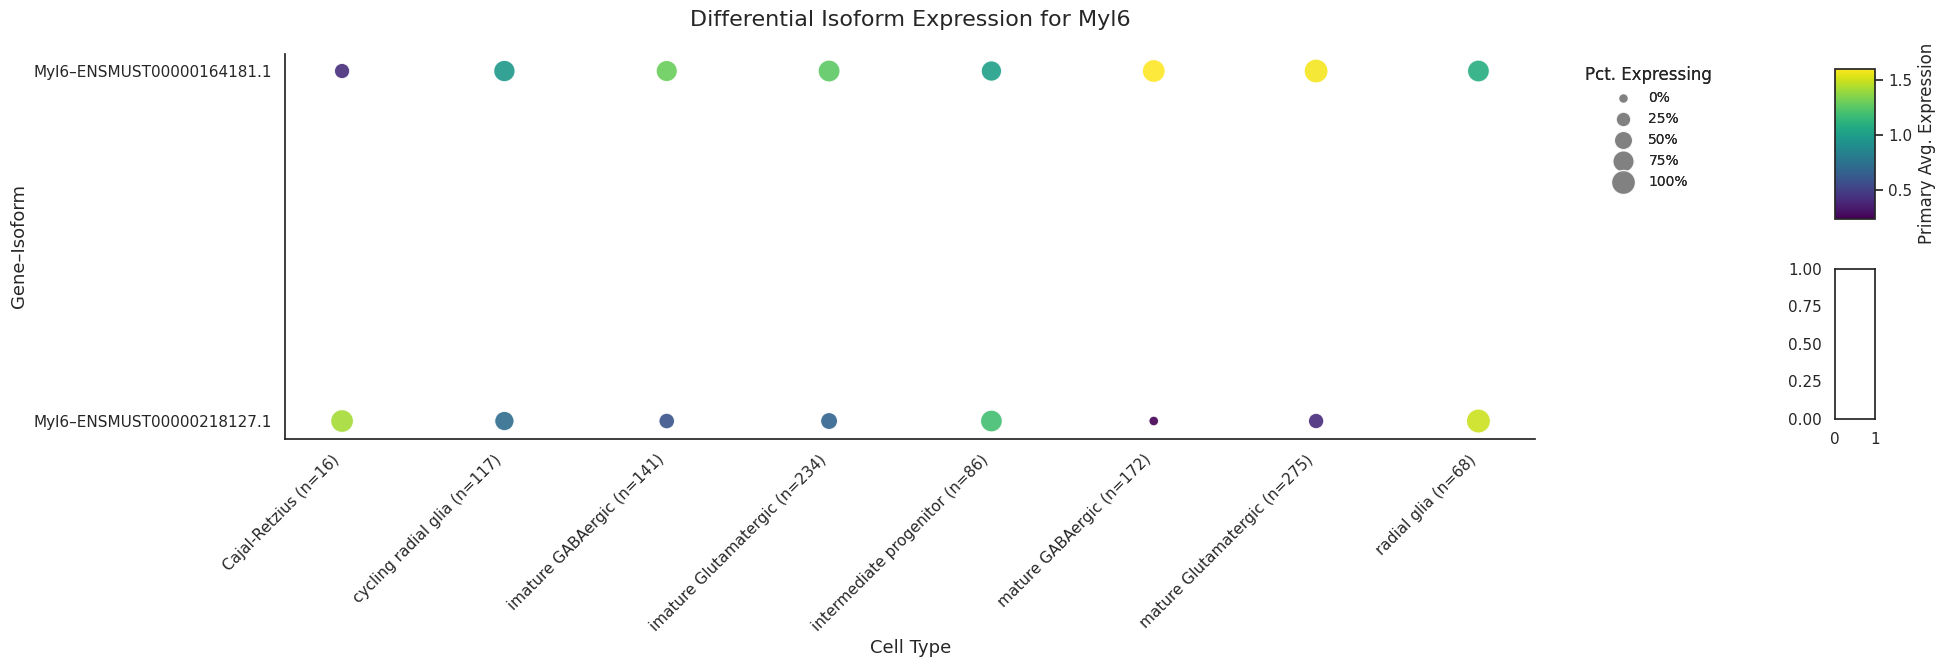

In [58]:
vs.plot_transcript_exspression_dotplot(adata_t, gene_id='Myl6', top_n =2)


|  comparison                                                         | What you will see                                                                                                                                                                                                                                                        | Biology                                                                                                                                                                                              |
| ----------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **radial glia / cycling RG / IPs** vs **both mature neuronal clusters** |  “embryonic” Myl6 isoform (exon‑skipping at the C‑terminus) dominates in progenitors; the “adult” isoform appears as cells exit the cell‑cycle (immature neurons) and is strongly enriched in mature Glut. & GABA clusters.  Cajal‑Retzius again keeps both. | This exon changes the EF‑hand Ca²⁺‑binding loop of the regulatory light chain, fine‑tuning actin–myosin contractility needed first for migration then for growth‑cone remodelling in mature axons/dendrites. |


    gene_id  effect_size      adj_pval
0      Clta    -0.325043  7.604639e-15
1       Pkm     0.192502  8.114709e-09
2      Myl6    -0.173967  7.183606e-06
3      Nnat     0.030385  2.186242e-03
4    Rpl35a     0.104280  5.651515e-03
5       Fus     0.131314  7.350967e-03
6     Cdc42    -0.126348  1.100965e-02
7    Mpped2     0.233255  2.911408e-02
8      Ly6h    -0.233921  4.190361e-02
9   Hnrnpa1     0.061662  4.430058e-02
10     Ttc3    -0.119490  4.914248e-02


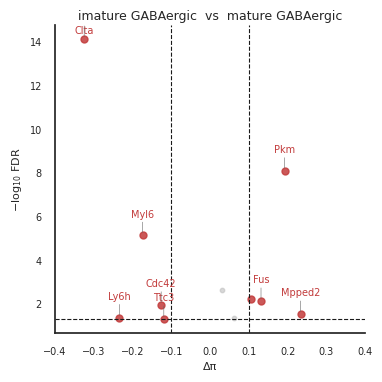

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter   # used inside the helper

# ── 1 · pick the two labels exactly as they occur in DIU_results ─────────
g1, g2 = "imature GABAergic", "mature GABAergic"  

b_switches = (DIU_results
                .loc[lambda d:
                     ((d.group_1 == g1) & (d.group_2 == g2)) |
                     ((d.group_1 == g2) & (d.group_2 == g1))]
                .sort_values("adj_pval")
                .reset_index(drop=True))

print(b_switches[["gene_id", "effect_size", "adj_pval"]].head(30))


# ── 2 · subset the DIU frame to this comparison (order-agnostic) ─────────
df_comp = DIU_results.loc[
    ((DIU_results.group_1 == g1) & (DIU_results.group_2 == g2)) |
    ((DIU_results.group_1 == g2) & (DIU_results.group_2 == g1))
].copy()

if df_comp.empty:
    raise ValueError("Requested comparison not found in DIU_results")

# ── 3 · draw the panel ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(4, 4))
draw_volcano_panel(
    ax,
    df_comp,
    fdr_cutoff=0.05,      # red if FDR < 5 %
    eff_cutoff=0.10,      # Δπ threshold lines
    top_n=8               # annotate the eight strongest switches
)
plt.show()

# (optional) save for your figure panel
# fig.savefig("volcano_NaiveB_vs_MemoryB.png", dpi=300, bbox_inches="tight")


In [37]:
top_n = get_top_n_isoforms(adata=adata, gene_id = 'Clta', top_n = 2, strip=True)

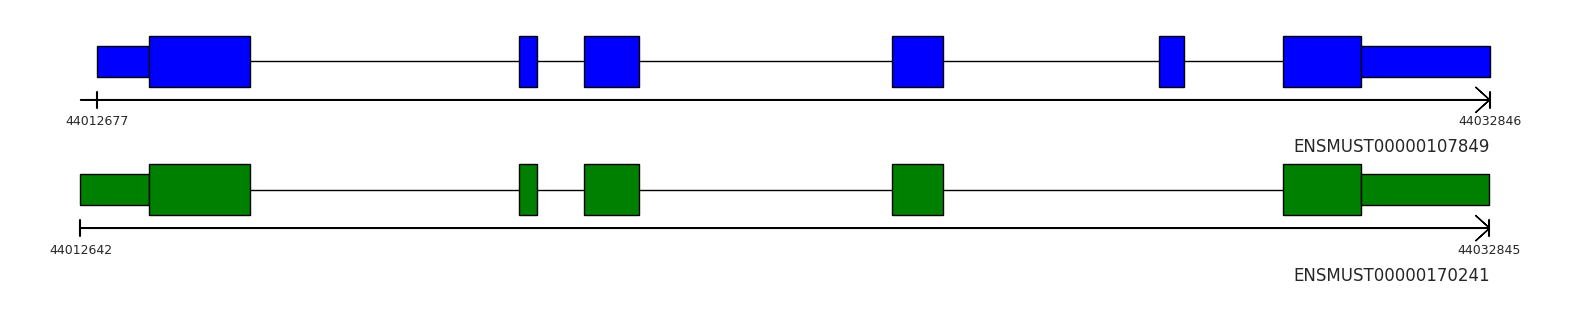

In [38]:
tp.draw_transcripts_list(transcripts_ids=top_n, draw_cds=True)

/tmp/ipykernel_140187/1183139680.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_df = expr_df.div(total, axis=0).assign(ct=groups.values).groupby("ct").mean().T * 100


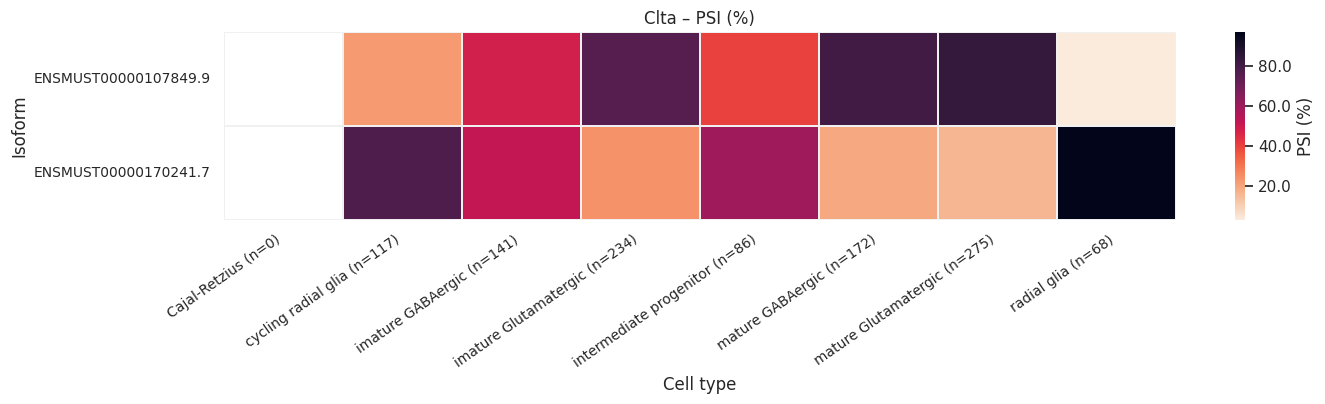

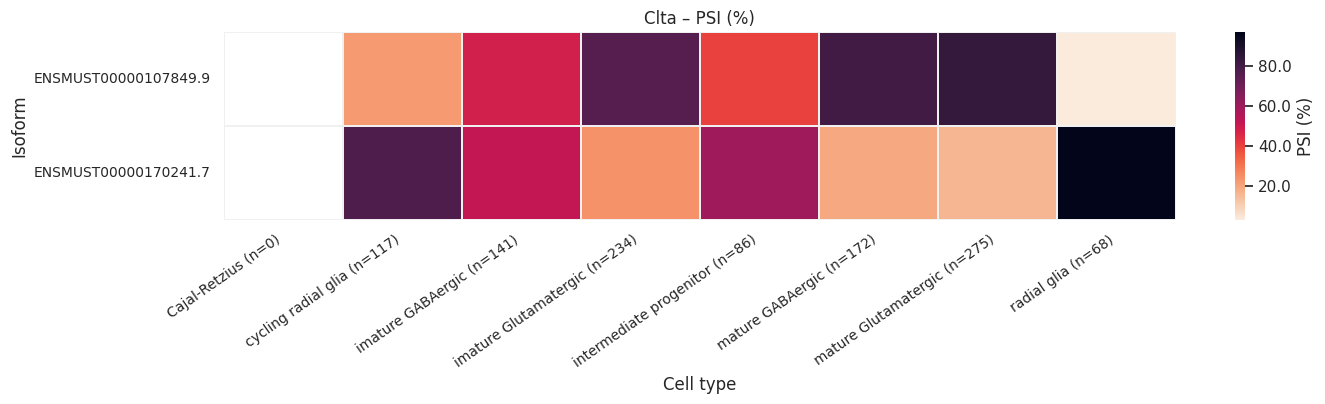

In [39]:
plot_isoform_heatmap(adata_lr=adata, cell_col='cell_type', gene_id='Clta', view_mode='PSI', top_n=2)

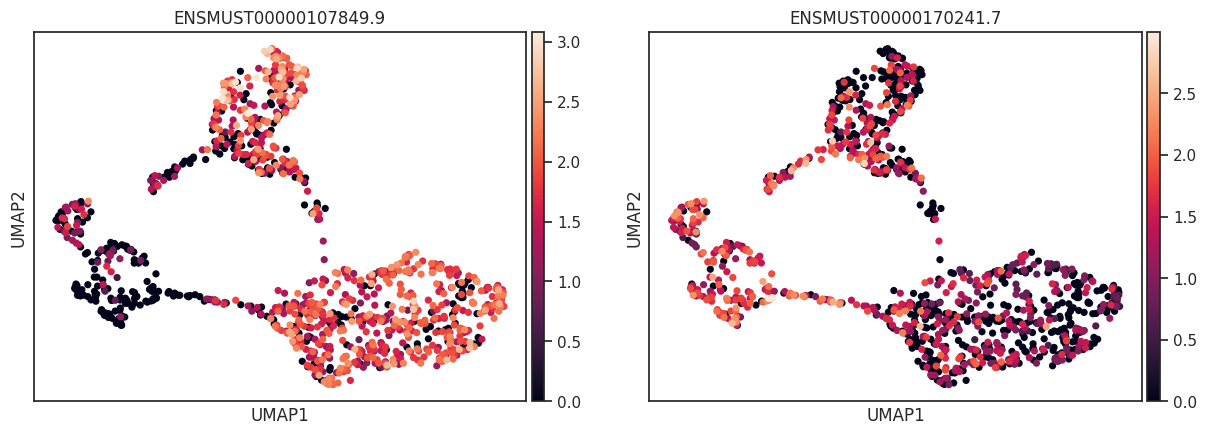

In [53]:
top_n = get_top_n_isoforms(adata=adata, gene_id = 'Clta', top_n = 2, strip=False)
vs.plot_transcripts(adata_t, transcripts=top_n)


/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/visuals.py:474: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right', fontsize=11)


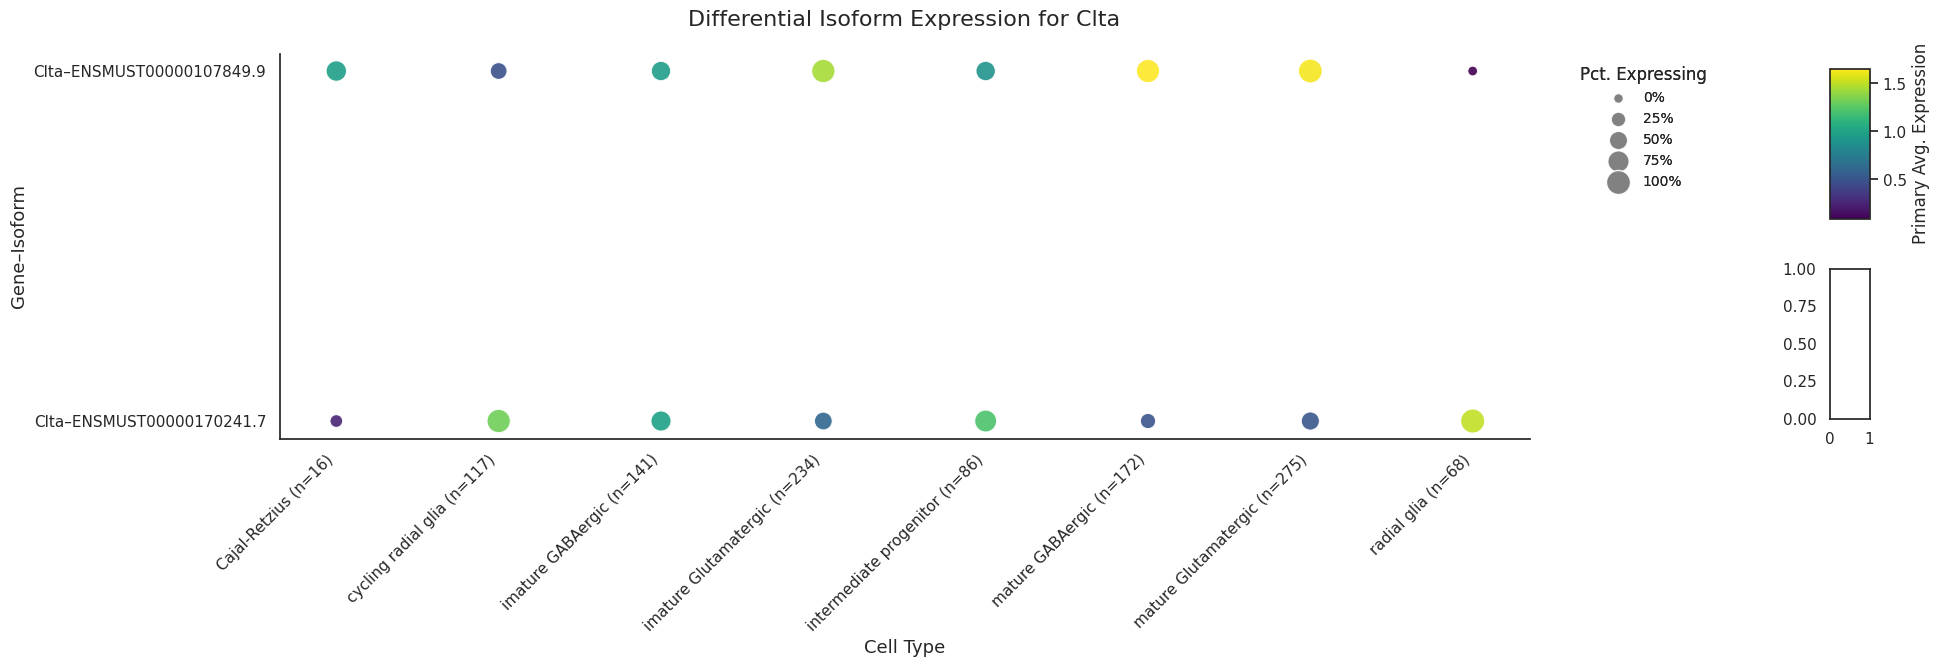

In [57]:
vs.plot_transcript_exspression_dotplot(adata_t, gene_id='Clta', top_n =2)


|  comparison                                                        | What you will see                                                                                                                                                                                   | Biology                                                                                                                                                                 |
| ---------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **immature → mature Glutamatergic**<br>**immature → mature GABAergic** | Clta‑204 (ENSMUST00000170241.7) is dominant in radial glia, cycling RG, IPs and both immature neuron clusters; Clta‑206 (ENSMUST00000107849.9) takes over almost completely in the two mature neuronal clusters.  Cajal‑Retzius cells stay mixed. | Alternative N‑terminal acidic peptide alters self‑assembly kinetics of the clathrin lattice, dovetailing with the jump in synaptic‑vesicle recycling demands as neurons mature. |


In [41]:
top_n = get_top_n_isoforms(adata=adata, gene_id = 'Pkm', top_n = 4, strip=True)

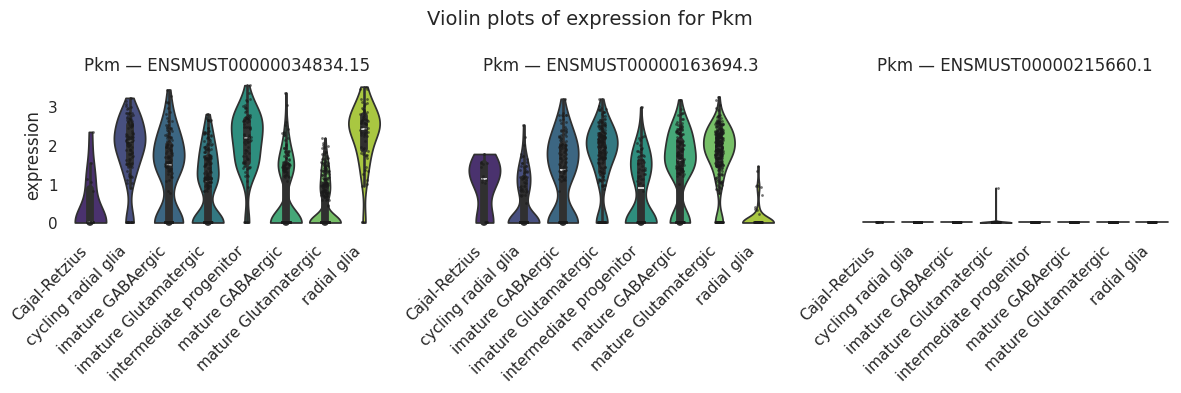

In [42]:
vs.plot_transcript_expression_violin(adata_t, gene_id='Pkm')


/tmp/ipykernel_140187/1183139680.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_df = expr_df.div(total, axis=0).assign(ct=groups.values).groupby("ct").mean().T * 100


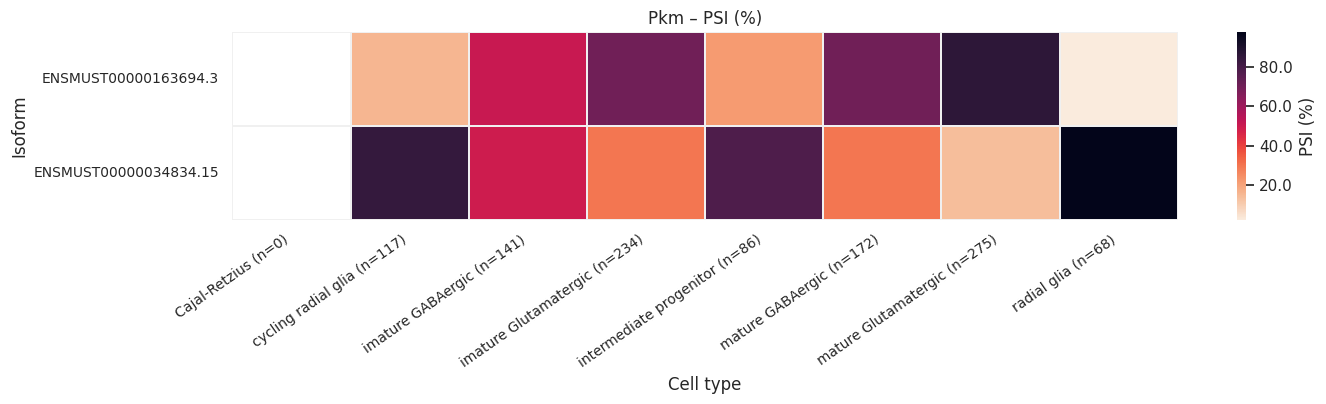

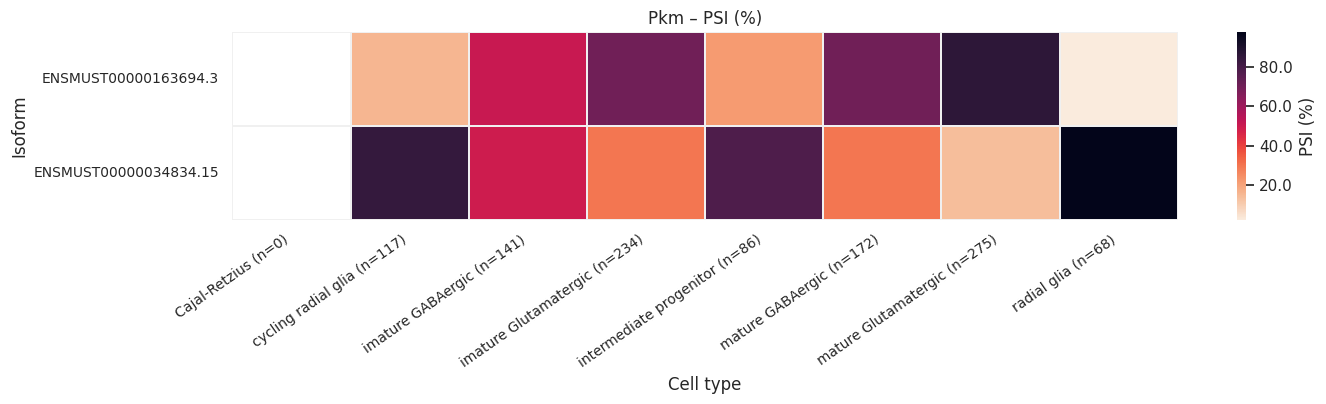

In [43]:
plot_isoform_heatmap(adata_lr=adata, cell_col='cell_type', gene_id='Pkm', view_mode='PSI')

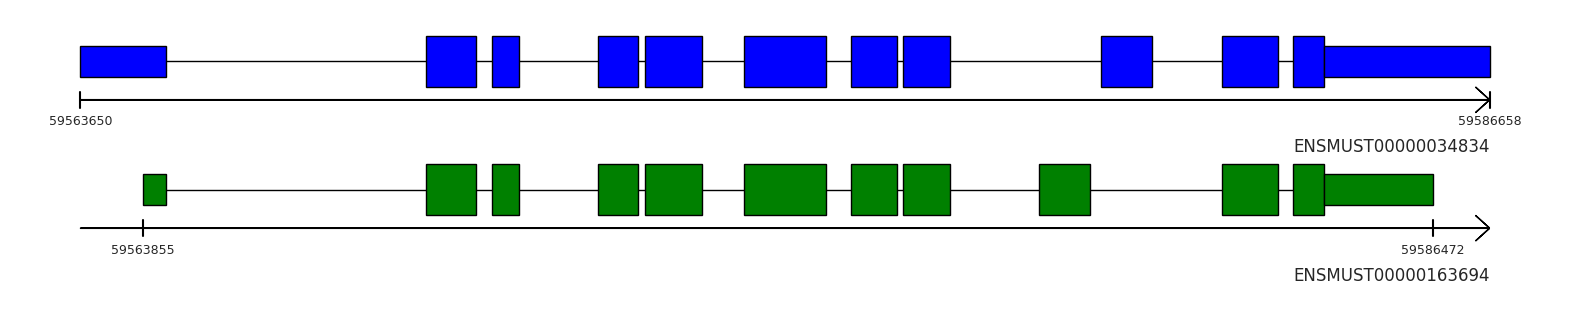

In [44]:
tp.draw_transcripts_list(transcripts_ids=top_n, draw_cds=True)

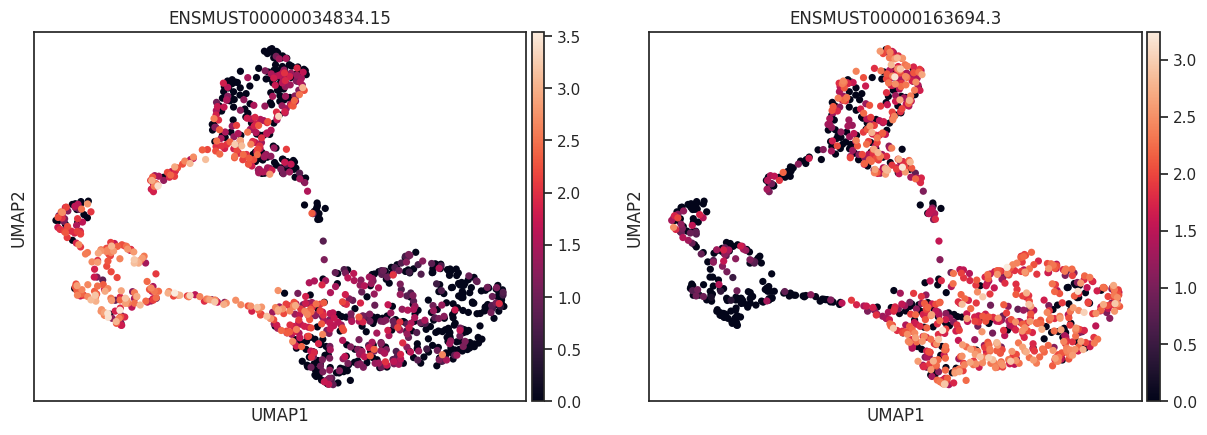

In [45]:
top_n = get_top_n_isoforms(adata=adata, gene_id = 'Pkm', top_n = 4, strip=False)
vs.plot_transcripts(adata_t, transcripts=top_n)


/home/train/longTREC/software/miniconda3/envs/Single_Cell/lib/python3.10/site-packages/allos/visuals.py:474: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right', fontsize=11)


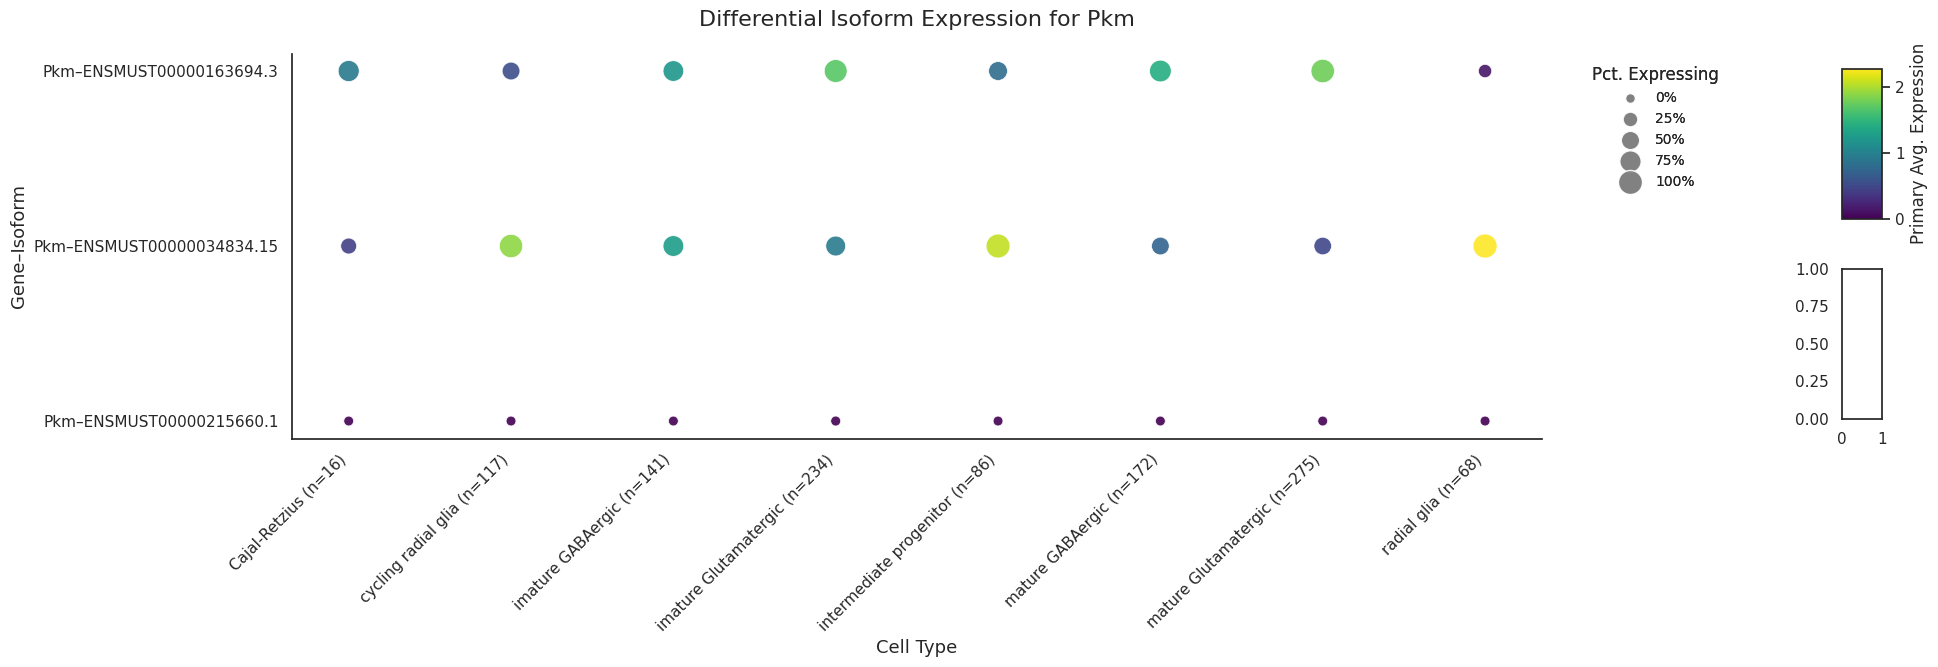

In [55]:
vs.plot_transcript_exspression_dotplot(adata_t, gene_id='Pkm')


Single cells tend to express dominantly one transcript isoform of Pkm (Pyruvate kinase‑M), and inspection shows PKM2 in dividing radial glia / cycling RG, with PKM1 appearing in maturing neurons. It is less dramatic than Clta or Myl6 but is a nice segue into metabolism (Warburg‑like vs oxidative).

Can you use the existing commands to :

1. Compare DIU across another pair of cell types?
2. Can you find and visualise another potential isoform switch?
3. Does it have any existing characterisation/validation in the litrature ? (use google, chatgpt, ensemble, etc)